# 012. Explaining and training the local model

## Review
We want to build our machine-learning model based on two fundamental observations:
- If there is no local source of water, the discharge at some point downstream is determined by the upstream points.
- If we see a rise in river levels/discharge that is not due to transport from upstream points, then there is a locally influencing factor.

This motivates splitting the flood forecast model into two parts:
1. The prediction of discharge at some point at day $t$, is possible using the upstream points' discharge of the previous days $\{$t-1, t-2, t-3$\}$, given that there is no local contribution. 

We suspect that a large portion of the local contribution is due to precipitation, therefore we exclude rainy days from the training dataset for this model.

2. The residual, i.e. the quantity that is not due to inflow from other river gridpoints, is modelled using ERA5 data. The model itself is designed to forecast the residual for one day, so that it is sufficient to select predictor gridpoints that are in the nearby surroundings. We expect precipitation to have the largest impact. Snow melting could be represented by some combination of airmass temperature (relative topography) and a snow cover variable.

Therefore we split the discharge forecasts into two models:
- The `TransportModel` is responsible for advection of water from upstream river to downstream river gridpoints. 
- The`LocalModel` is responsible for the difference to observed values. It is driven by nearby gridpoints' information.

## Part 2: Training the local model

Let's import some packages.

In [1]:
import os, warnings
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

import dask
dask.config.set(scheduler='threading')

import xarray as xr
from dask.diagnostics import ProgressBar
from joblib import Parallel

To import our custom packages, we are setting the PYTHONPATH in `link_src`.

In [2]:
import link_src
from python.aux.utils import open_data
from python.aux.ml_flood_config import path_to_data

For the LocalModel, we use the ERA5 variables as predictors and the GloFAS discharge reanalysis for the predictand = (reanalysis - transport_model_forecast).

In [3]:
era5 = open_data(path_to_data+'danube/', kw='era5')

In [4]:
glofas = open_data(path_to_data+'danube/', kw='glofas_ra')

We prepare the predictor data, i.e. features by converting units. We don't need to interpolate here ?!

In [5]:
if 'tp' in era5:
    era5['tp'] = era5['tp']*1000
else:
    era5['tp'] = (era5['cp']+era5['lsp'])*1000

# no interpolation necessary

era5['reltop'] = era5['z'].sel(level=500) - era5['z'].sel(level=850)

era5['q_mean'] = era5['q'].mean('level')

## Prepare training data for the LocalModel
The predictors and predictand are as follows:
predictors = ERA5 variables of the last three days (t-1, t-2, t-3)
predicand = (reanalysis - transport_model_forecast) (t)

To achieve this, we add the variables three times as new variable to the training data `X` (with an additional ´-1´ to show that they are shifted by one for example). Each time the data is shifted by one day. Finally we drop the variables at the current day $t$ so that we are left with 3 variables, e.g. discharges at (t-1, t-2, t-3).

# check

The predictand variable will be create for each gridpoint just before training the local model because we have to open the transport model from disk, use it to predict the mean flow and then train the local model on the difference.

In [54]:
listofpredictors = ['reltop', 'q_mean', 'tp', 'ro']
X_local = era5[listofpredictors]

shifts = range(1,4)
#X = add_shifted_predictors(glofas, shifts, variables='all')
#X = X.drop('dis')  # current dis is to be predicted, is not a feature

In [55]:
X_local

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 53, time: 13545)
Coordinates:
  * longitude  (longitude) float32 7.0 7.25 7.5 7.75 ... 19.25 19.5 19.75 20.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    reltop     (time, latitude, longitude) float32 dask.array<shape=(13545, 13, 53), chunksize=(13545, 13, 53)>
    q_mean     (time, latitude, longitude) float32 dask.array<shape=(13545, 13, 53), chunksize=(13545, 13, 53)>
    tp         (time, latitude, longitude) float32 dask.array<shape=(13545, 13, 53), chunksize=(13545, 13, 53)>
    ro         (time, latitude, longitude) float32 dask.array<shape=(13545, 13, 53), chunksize=(13545, 13, 53)>
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.6
    history:      Thu May 30 12:35:16 2019: cdo dayavg /home/srvx11/lehre/use...
    CDO:          Cl

### additionally
we need the discharge of the last days for the transport model forecast

In [56]:
from python.aux.utils_flowmodel import add_shifted_predictors

In [57]:
shifts = range(1,4)
X_flow = add_shifted_predictors(glofas, shifts, variables='all')
X_flow = X_flow.drop('dis')  # current dis is to be predicted, is not a feature

Next, we select the training and validation periods,

In [58]:
N_train = dict(time=slice(None, '1990'))
N_valid = dict(time=slice('1990', '1995'))

We determine the location to save the model object and plots about the quality of training and the used features in space (the upstream river gridpoints).

In [59]:
# kind, lat, lon will be replaced!
main_dir = '/home/srvx11/lehre/users/a1254888/ipython/ml_flood/'
ff_mod = main_dir+'/models/localmodel/danube/kind/point_lat_lon_localmodel.pkl'
ff_hist = main_dir+'/models/localmodel/danube/kind/point_lat_lon_history.png'
ff_valid = main_dir+'/models/localmodel/danube/kind/point_lat_lon_validation.png'


ff_mod_transport = main_dir+'/models/flowmodel/danube/kind/point_lat_lon_flowmodel.pkl'

### Model selection
Now we can select which model to use for the LocalModel.

We choose the neural network here, where scaling is done within the model, but we could use other models with feature scaling and feature selection (principal component analysis) too.

In [60]:
from python.aux.floodmodels import LocalModel

In [61]:
#pipe = Pipeline([('scaler', StandardScaler()),
#                 #('pca', PCA(n_components=6)),
#                 ('model', FlowModel('Ridge', dict(alphas=np.logspace(-3, 2, 6)))),])

model = LocalModel('neural_net', dict(epochs=1000,))
pipe = Pipeline([#('pca', PCA(n_components=6)),
                  ('model', model),])

### Spatial feature selection
In contrast to the transport model we have no background info which gridpoints influence the predictand the most, so we use dimensionality reduction approach and/or let the model decide which gridpoints are most relevant.

The only hard constraint for the LocalModel is the influence radius of 1.5 degrees latitude/longitude, about 170 km and that the gridpoints have to lie within the catchment basin of the point.

In [62]:
from python.aux.utils_flowmodel import get_mask_of_basin

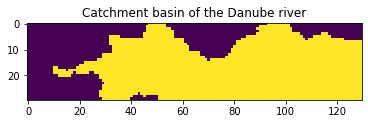

In [63]:
mask_catchment = get_mask_of_basin(glofas['dis'].isel(time=0), 'Danube')
plt.imshow(mask_catchment.astype(int))
plt.title('Catchment basin of the Danube river')
plt.show()

In [64]:
def select_riverpoints(dis):
    return (dis > 10)

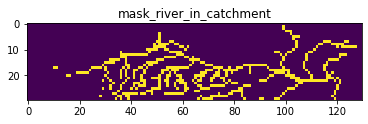

In [65]:
dis_map_mean = glofas['dis'].mean('time')
is_river = select_riverpoints(dis_map_mean)

mask_river_in_catchment = is_river & mask_catchment

plt.imshow(mask_river_in_catchment.astype(int))
plt.title('mask_river_in_catchment')
plt.show()

## Preparing the training tasks to run in parallel
Before we can start training all the gridpoints models in parallel, we have to prepare all the work in a list which is then worked off.

We iterate over the array of river gridpoints, where the localmodel shall contribute to discharge and 
append a `delayed` function call to the `task_list`, which is worked off later on by `joblib`'s `Parallel()` function.

Within the `train_localmodel()`, the TransportModel is called to predict the background flow, then the LocalModel is trained on the residual (error) of the TransportModel.

The two models can then be run 14 times to produce a 14 day forecast.
From a physics point of view, the combination model uses GloFAS discharge as initial conditions and ERA5 as boundary conditions.

In [76]:
np.seterr(divide='ignore', invalid='ignore')
from joblib import Parallel, delayed  #  parallel computation
from joblib import dump, load   # saving and loading pipeline objects ("models")
from sklearn.base import clone
from python.aux.utils_flowmodel import select_upstream, preprocess_reshape_flowmodel
@delayed
def train_localmodel(X_local, X_flow, pipe,
                    lat, lon,
                    f_mod, f_hist, f_valid, 
                    f_mod_transport, 
                    debug=False):
    """Train the local model, save it to disk."""

    upstream = select_upstream(mask_river_in_catchment, lat, lon, basin='Danube')
    N_upstream = int(upstream.sum())
    lats, lons = str(lat), str(lon)

    if not os.path.isfile(f_mod_transport) or N_upstream <= 5:
        if debug:
            print(lats, lons, 'is spring.')  # assume constant discharge
            y_flow = glofas['dis'].sel(latitude=lat, longitude=lon).mean('time')
    else:
        dis_point = glofas['dis'].sel(latitude=float(lat), longitude=float(lon))
        tp_box = era5['tp'].sel(latitude=slice(lat+1.5, lat-1.5),
                                longitude=slice(lon-1.5, lon+1.5))
        hasprecip = tp_box.mean(['longitude', 'latitude']) > 0.5
        
        if debug:
            print('predict mean flow using the transport model...')
            print('upstream:', N_upstream)
            
        # prepare the transport model input data
        Xt = X_flow.where(upstream & hasprecip, drop=True)
        if debug:
            plt.imshow(upstream.astype(int))
            plt.title('upstream')
            plt.show()
        
        yt = dis_point
        Xda, yda, time = preprocess_reshape_flowmodel(Xt, yt)
        X_flow = Xda
        if debug:
            print(X_flow.shape)
        
        ppipe = load(f_mod_transport)
        y_flow = ppipe.predict(X_flow)
        # background forecast finished, calculate residual now
        y_res = dis_point - y_flow
        
        Xt = X_local.sel(latitude=slice(lat+1.5, lat-1.5),
                          longitude=slice(lon-1.5, lon+1.5))

        Xt = Xt.where(hasprecip)
        yt = y_res
        Xda, yda, time = preprocess_reshape_flowmodel(Xt, yt)

        X_train = Xda.loc[N_train]
        y_train = yda.loc[N_train]
        X_valid = Xda.loc[N_valid]
        y_valid = yda.loc[N_valid]

        if debug:
            print(X_train.shape, y_train.shape)
            print(X_valid.shape, y_valid.shape)
        ppipe = clone(pipe)
        history = ppipe.fit(X_train.values, y_train.values,
                           model__validation_data=(X_valid.values,
                                                   y_valid.values))

        dump(ppipe, f_mod)

        try:
            h = history.named_steps['model'].m.model.history

            # Plot training & validation loss value
            fig, ax = plt.subplots()
            ax.plot(h.history['loss'], label='loss')
            ax.plot(h.history['val_loss'], label='val_loss')
            plt.title('Model loss')
            ax.set_ylabel('Loss')
            ax.set_xlabel('Epoch')
            plt.legend() #['Train', 'Test'], loc='upper left')
            ax.set_yscale('log')
            fig.savefig(f_hist); plt.close('all')
        except Exception as e:
            warnings.warn(str(e))

        ppipe = load(f_mod)
        y_m = ppipe.predict(X_valid)

        try:
            fig, ax = plt.subplots(figsize=(10,4))
            y_valid.plot(ax=ax, label='reanalysis')
            y_m.plot(ax=ax, label='prediction')
            plt.legend()
            fig.savefig(f_valid); plt.close('all')
        except Exception as e:
            warnings.warn(str(e))

In [77]:
def mkdir(d):
    if not os.path.isdir(d):
        os.makedirs(d)
        
def replace(string: str, old_new: dict):
    for o, n in old_new.items(): 
        string = string.replace(o, str(n))
    return string

In [82]:
mkdir(os.path.dirname(ff_mod).replace('kind', model.kind))
task_list = []

for lon in mask_river_in_catchment.longitude:
    for lat in mask_river_in_catchment.latitude:
        if mask_river_in_catchment.sel(latitude=lat, longitude=lon) == 1:  # valid danube river point
            lat, lon = float(lat), float(lon)
            lat, lon = 48.35, 15.650000000000034
            #print(lat, lon)

            f_mod = replace(ff_mod, dict(lat=lat, lon=lon, kind=model.kind))
            f_hist = replace(ff_hist, dict(lat=lat, lon=lon, kind=model.kind))
            f_valid = replace(ff_valid, dict(lat=lat, lon=lon, kind=model.kind))

            f_mod_transport = replace(ff_mod_transport, dict(lat=lat, lon=lon, kind=model.kind))

            transport_exists = os.path.isfile(f_mod_transport)
            localmodel_exists = os.path.isfile(f_mod)

            if transport_exists and not localmodel_exists:
                task = train_localmodel(X_local, X_flow, pipe,
                                            lat, lon,
                                            f_mod, f_hist, f_valid, 
                                            f_mod_transport, 
                                            debug=False)
                task_list.append(task)


How many tasks are there?

In [83]:
len(task_list)

582

### Actual computation
The actual computation can be done for example with these two packages. We found `joblib` to work easier out of the box because we have independent computations.

dask:
1. Import `dask`
2. Decorate the function to parallelize with `@dask.delayed`
3. Call
``with ProgressBar():
    dask.compute(task_list)``
    
joblib:
1. Import `from joblib import delayed, Parallel`
2. Decorate the function to parallelize with `@delayed`
3. Call
``Parallel(n_jobs=20, verbose=10)(task_list)``

In [91]:
Parallel(n_jobs=20, verbose=10)(task_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  7.4min


ValueError: Error when checking input: expected sequential_2_input to have shape (216,) but got array with shape (864,)

The work is now finished and saved in our folder.

In [23]:
files = os.listdir(os.path.dirname(f_mod))
len(files)

50

Let's look at some of the results:

In [85]:
from IPython.display import Image
ddir = "../models/localmodel/danube/neural_net/"

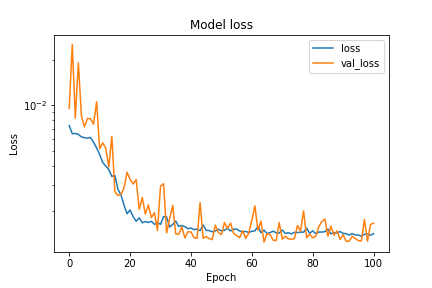

In [89]:
Image(ddir+'point_48.65_16.850000000000023_history.png')

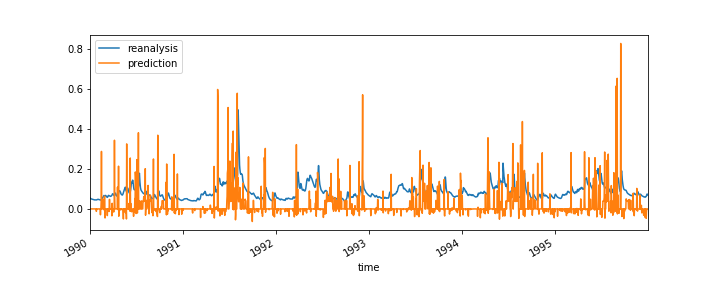

In [90]:
Image(ddir+'point_48.65_16.850000000000023_validation.png')